In [4]:
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import scipy.optimize
from scipy.optimize import minimize
from scipy.special import jv
#from scipy.ndimage import gaussian_filter1d
import sys


import qgm
from qgm import image, parameter, filter, data, fitting, function
from qgm.image import pixel_shift
from qgm import search_atoms
from qgm.deconvolution import deconvolution

cmap = image.generate_cmap(['#330000', 'r', 'w'])

In [5]:
date = '20220624'
dataNo = 4
scanNo = 4

In [6]:
path = r"./"+date
path_img = path + r"/data" + str('%03d' % dataNo) + "/raw"
path_scan = path + r"/scandir/Scan" + str('%03d' % scanNo) + '.txt'
path_param = path + r"/scandir/Parameters" + str('%03d' % scanNo) + '.txt'
scan_data = pd.read_csv(path_scan, delimiter='\t')

In [7]:
share = Path(path_img)
if share.exists():
    trans_files = list(Path(path_img).glob('seq*_trans001.tiff'))
    flat_files = list(Path(path_img).glob('seq*_flat001.tiff'))
    update_files = list(Path(path_img).glob('seq*_update001.tiff'))
else:
    print('No images')

img_flat_ave =[]
img_trans_ave = []
img_trans_list = []
for N in range(len(trans_files)):
    img_flat_ave += [np.array(Image.open(flat_files[N]))]
    img_trans_ave += [np.array(Image.open(trans_files[N]))]
img_flat_ave = np.average(img_flat_ave,axis=0)
img_trans_ave =np.average(img_trans_ave,axis=0) -img_flat_ave
for N in range(len(trans_files)):
    img_trans_list += [np.array(Image.open(trans_files[N])) - img_flat_ave]

Text(0.5, 1.0, 'The number of images = 292')

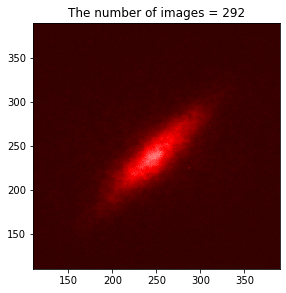

In [8]:
vmin = 0
vmax = 1500
xlim_1 = 110
xlim_2 = 390
ylim_1 = 110
ylim_2 = 390

fig =plt.figure(figsize=[15,10])
ax1 = fig.add_subplot(2,3,1)
mappable =ax1.pcolormesh(img_trans_ave, cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
ax1.set_aspect('equal')
ax1.set_xlim(xlim_1,xlim_2)
ax1.set_ylim(ylim_1,ylim_2)
ax1.set_title("The number of images = %d"%(len(img_trans_list)))

In [17]:
cx = 247
cy = 240
wx = 10
wy = 10
shift_dx_list = [0, 16, -16, 32, -32]
shift_dy_list = [0, 16, -16, 32, -32]

subROI_parameters_list = []

def createSubROI(mainROI_cx, mainROI_cy, wx, wy, shift_dx=0, shift_dy=0):
    subROI_x0 = mainROI_cx + shift_dx - wx
    subROI_x1 = mainROI_cx + shift_dx + wx
    subROI_y0 = mainROI_cy + shift_dy - wy
    subROI_y1 = mainROI_cy + shift_dy + wy
    subROI_xmesh, subROI_ymesh = np.meshgrid(np.arange(subROI_x0,subROI_x1), np.arange(subROI_y0,subROI_y1))
    return subROI_xmesh, subROI_ymesh, subROI_x0, subROI_x1, subROI_y0, subROI_y1

for i in range(len(shift_dx_list)):
    subROI_parameters_temp = createSubROI(cx,cy, wx, wy, shift_dx_list[i], shift_dy_list[i])
    subROI_parameters_list.append(subROI_parameters_temp)

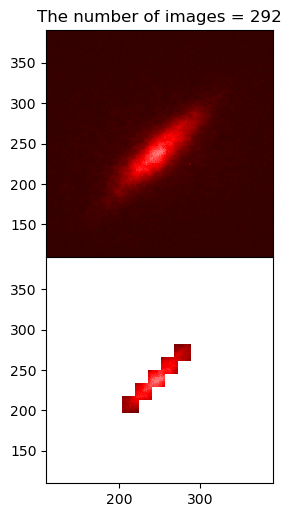

In [18]:
vmin = 0
vmax = 1500
# xlim_1 = 120
# xlim_2 = 360
# ylim_1 = 130
# ylim_2 = 370

sampleImages_list = [img_trans_ave]
sample_list = [0]
fig, axs = plt.subplots(ncols=len(sampleImages_list), nrows=2, figsize=[6, 6], dpi=100, sharex=True, sharey=True)
axs = np.reshape(axs, [-1, ])
for i in range(len(sampleImages_list)*2):
    if i<len(sampleImages_list):
        axs[i].pcolormesh(sampleImages_list[i], vmin=vmin, vmax=vmax, cmap=cmap, shading='auto')
        axs[i].set_title("The number of images = %.d"%(len(img_trans_list)))
    else:
        for j in range(len(shift_dx_list)):
            axs[i].pcolormesh(subROI_parameters_list[j][0],subROI_parameters_list[j][1],sampleImages_list[i-len(sampleImages_list)][subROI_parameters_list[j][4]:subROI_parameters_list[j][5],subROI_parameters_list[j][2]:subROI_parameters_list[j][3]], vmin=vmin, vmax=vmax, cmap=cmap, shading='auto')
    axs[i].set_aspect('equal')
    axs[i].set_xlim(xlim_1,xlim_2)
    axs[i].set_ylim(ylim_1,ylim_2)
fig.subplots_adjust(hspace=0, wspace=0)
plt.show()

In [19]:
center_list = []
side1_list = []
side2_list = []
visibility_list = []

for j in range(len(trans_files)):
    center_list.append(np.sum(img_trans_list[j][subROI_parameters_list[0][4]:subROI_parameters_list[0][5],subROI_parameters_list[0][2]:subROI_parameters_list[0][3]])/np.sum(img_trans_list[j]))
    side1_list.append(np.sum(list(map(lambda x: img_trans_list[j][subROI_parameters_list[x][4]:subROI_parameters_list[x][5],subROI_parameters_list[x][2]:subROI_parameters_list[x][3]], range(1,3,1))))/np.sum(img_trans_list[j]))
    side2_list.append(np.sum(list(map(lambda x: img_trans_list[j][subROI_parameters_list[x][4]:subROI_parameters_list[x][5],subROI_parameters_list[x][2]:subROI_parameters_list[x][3]], range(3,5,1))))/np.sum(img_trans_list[j]))
    visibility_list.append((center_list[-1]-side1_list[-1]+side2_list[-1])/(center_list[-1]+side1_list[-1]+side2_list[-1]))

x_list = np.arange(0,len(trans_files),1)

No handles with labels found to put in legend.


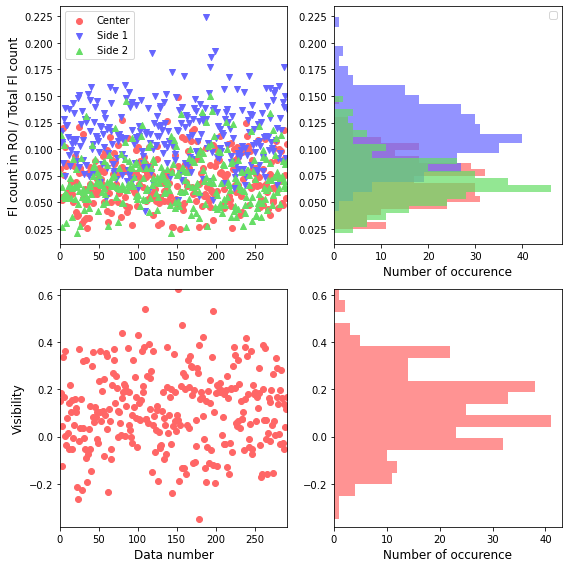

In [21]:
fig =plt.figure(figsize=[8,8])
ax1 = fig.add_subplot(2,2,1)
ax1.scatter(x_list,center_list,  marker='o', c='#ff6666',label='Center')
ax1.scatter(x_list, side1_list, marker='v',c='#6666ff',label='Side 1')
ax1.scatter(x_list, side2_list, marker='^',c='#66dd66',label='Side 2')
ax1.set_xlabel(r'Data number',fontsize=12)
ax1.set_ylabel('Fl count in ROI / Total Fl count',fontsize=12)
ax1.set_xlim(0,len(trans_files))
ax1.legend()

ax2 = fig.add_subplot(2,2,2)
ax2.hist(np.array(center_list),bins=20,color='#ff6666', alpha=0.7,orientation='horizontal')
ax2.hist(np.array(side1_list),bins=20,color='#6666ff', alpha=0.7,orientation='horizontal')
ax2.hist(np.array(side2_list),bins=20,color='#66dd66', alpha=0.7,orientation='horizontal')
# ax2.set_ylim(1.1*np.min(visibility_list),1/1*np.max(visibility_list))
ax2.set_xlabel('Number of occurence',fontsize=12)
ax2.legend()


ax3 = fig.add_subplot(2,2,3)
ax3.scatter(x_list,visibility_list,  marker='o', c='#ff6666',label='Visibility')
ax3.set_xlabel(r'Data number',fontsize=12)
ax3.set_ylabel('Visibility',fontsize=12)
ax3.set_xlim(0,len(trans_files))
ax3.set_ylim(1.1*np.min(visibility_list),1/1*np.max(visibility_list))

ax4 = fig.add_subplot(2,2,4)
ax4.hist(np.array(visibility_list),bins=20,color='#ff6666', alpha=0.7,orientation='horizontal')
ax4.set_ylim(1.1*np.min(visibility_list),1/1*np.max(visibility_list))
ax4.set_xlabel('Number of occurence',fontsize=12)

plt.tight_layout()

In [36]:
threshold = 0.1

post_selected_images = []

for i in range(len(trans_files)):
    if visibility_list[i] < threshold:
        post_selected_images.append(img_trans_list[i])

post_selected_images_ave = np.average(post_selected_images,axis=0)

Text(0.5, 1.0, 'Threshold = 0.1, The number of images = 137, Total number=292')

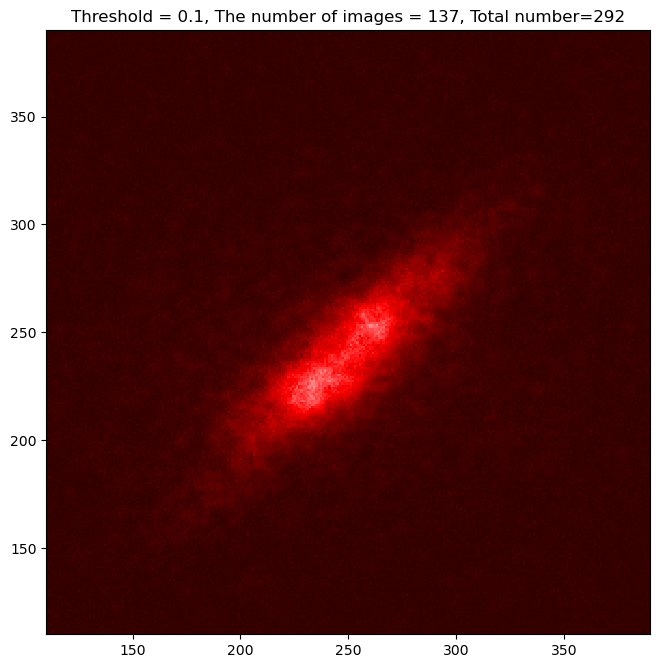

In [37]:
vmin = 0
vmax = 1500
xlim_1 = 110
xlim_2 = 390
ylim_1 = 110
ylim_2 = 390

fig =plt.figure(figsize=[8,8],dpi=100)
ax1 = fig.add_subplot(1,1,1)
mappable =ax1.pcolormesh(post_selected_images_ave, cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
ax1.set_aspect('equal')
ax1.set_xlim(xlim_1,xlim_2)
ax1.set_ylim(ylim_1,ylim_2)
ax1.set_title("Threshold = %.01f, The number of images = %d, Total number=%d"%(threshold, len(post_selected_images), len(img_trans_list)))

In [38]:
threshold = -0

post_selected_images = []

for i in range(len(trans_files)):
    if visibility_list[i] < threshold:
        post_selected_images.append(img_trans_list[i])

post_selected_images_ave = np.average(post_selected_images,axis=0)

Text(0.5, 1.0, 'Threshold = 0.0, The number of images = 73, Total number=292')

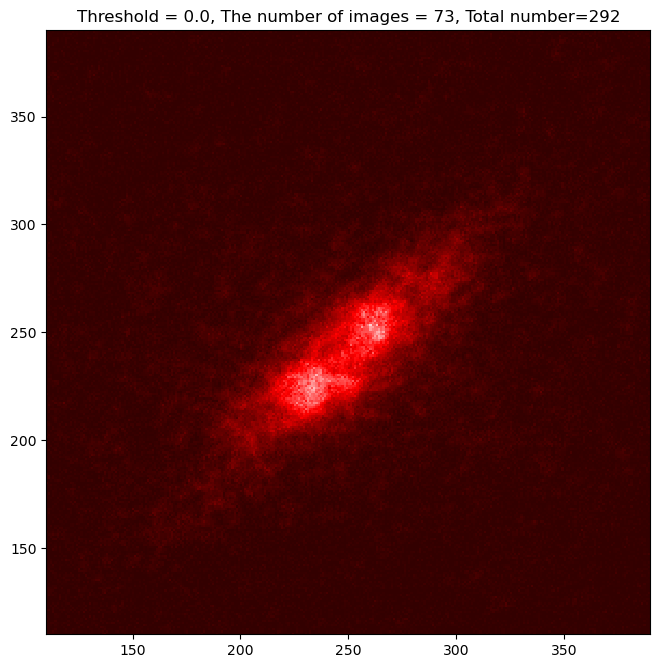

In [39]:
fig =plt.figure(figsize=[8,8],dpi=100)
ax1 = fig.add_subplot(1,1,1)
mappable =ax1.pcolormesh(post_selected_images_ave, cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
ax1.set_aspect('equal')
ax1.set_xlim(xlim_1,xlim_2)
ax1.set_ylim(ylim_1,ylim_2)
ax1.set_title("Threshold = %.01f, The number of images = %d, Total number=%d"%(threshold, len(post_selected_images), len(img_trans_list)))

In [40]:
threshold = -0.1

post_selected_images = []

for i in range(len(trans_files)):
    if visibility_list[i] < threshold:
        post_selected_images.append(img_trans_list[i])

post_selected_images_ave = np.average(post_selected_images,axis=0)

Text(0.5, 1.0, 'Threshold = -0.1, The number of images = 29, Total number=292')

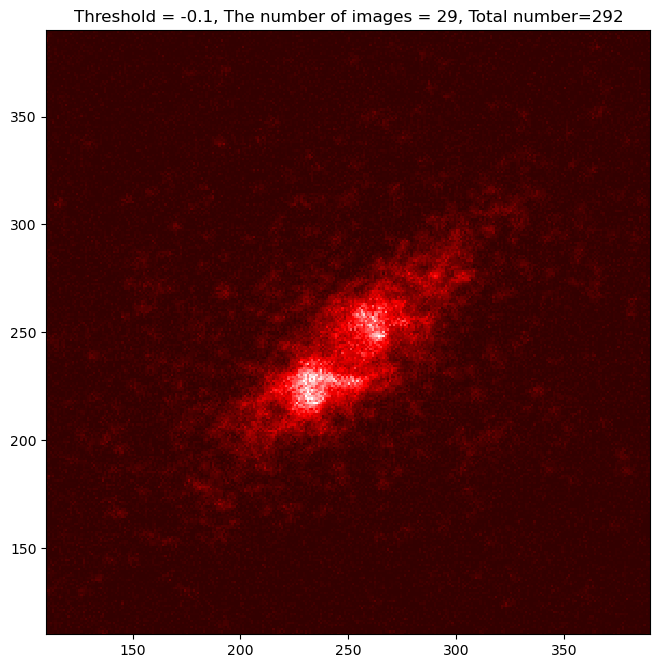

In [41]:
fig =plt.figure(figsize=[8,8],dpi=100)
ax1 = fig.add_subplot(1,1,1)
mappable =ax1.pcolormesh(post_selected_images_ave, cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
ax1.set_aspect('equal')
ax1.set_xlim(xlim_1,xlim_2)
ax1.set_ylim(ylim_1,ylim_2)
ax1.set_title("Threshold = %.01f, The number of images = %d, Total number=%d"%(threshold, len(post_selected_images), len(img_trans_list)))